# Detecting gradients with suave

## Imports

In [15]:
import numpy as np
import scipy
from scipy.interpolate import BSpline
from scipy.interpolate import _bspl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 200
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium',
         'figure.autolayout': True,
         'figure.figsize': (4,3),
         'text.usetex': True,
         'text.latex.preamble': [r"\usepackage{bm}"]}
pylab.rcParams.update(params)

%load_ext autoreload
%autoreload 2
from colors_labels import *
import bao_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import Corrfunc
from Corrfunc.io import read_fortran_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi

## Loading and setup

Load in a test catalog:

In [3]:
realization = 0
boxsize = 750
#nbar = '2e-4'
nbar = '5e-5'
cat_tag = f'_L{boxsize}_n{nbar}_z057_patchy'
cat_fn = f'../catalogs/lognormal/cat{cat_tag}_lognormal_rlz{realization}.bin'
cf_tag = f"_gradient_bao_single"

In [4]:
boxsize = 750.0
x, y, z = read_fortran_catalog(cat_fn)
nd = len(x)
print("Number of data points:",nd)

Number of data points: 21682


Generate a random catalog:

In [5]:
randmult = 2
nr = nd*randmult
xr = np.random.rand(nr)*float(boxsize)
yr = np.random.rand(nr)*float(boxsize)
zr = np.random.rand(nr)*float(boxsize)
print("Number of data points:", nr)

Number of data points: 43364


Set the parameters for suave:

In [6]:
rmin = 40.0
rmax = 140.0
ntopbins = 10
r_edges = np.linspace(rmin, rmax, ntopbins+1) #this is a dummy for now, don't need for gradient
ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)

nmubins = 1
mumax = 1.0
periodic = False #assume non-periodic for gradient finding!
nthreads = 1
verbose = False

proj_type = 'gradient'
weight_type = 'pair_product_gradient'
projfn = None
nprojbins = ntopbins*4
loc_pivot = [boxsize/2., boxsize/2., boxsize/2.]

kwargs = {'cf_tag_bao':'_baoiter_cosmob17_adaptive2'}
kwargs['Nr'] = realization
projfn, nprojbins, projfn_bao, amps_bao = bao_utils.get_gradient_bao_params(cat_tag, cf_tag, **kwargs)

We need weights for the gradient function. The code expects an array of shape (n_weights, n_data). The first weight is the general weight for the galaxy, e.g. for systematics correction; for now we take it to be 1 for all galaxies, as these are theory boxes. The second weight is the x position of the galaxies, and the third and fourth the y and z positions respectively. 

In [7]:
weights = np.array([np.ones(len(x)), x-loc_pivot[0], y-loc_pivot[1], z-loc_pivot[2]])
weights_r = np.array([np.ones(len(xr)), xr-loc_pivot[0], yr-loc_pivot[1], zr-loc_pivot[2]])

## Run suave with gradient mode

In [10]:
dd_res, dd_proj, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("DD:", np.array(dd_proj))

dr_res, dr_proj, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           X2=xr, Y2=yr, Z2=zr, weights2=weights_r, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("DR:", np.array(dr_proj))

rr_res, rr_proj, qq_proj = DDsmu(1, nthreads, r_edges, mumax, nmubins, xr, yr, zr, weights1=weights_r, 
                                 proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                                 periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("RR:", np.array(rr_proj))

DD: [  24882.75987221 -167958.46173299  -86310.10767628  -75965.23929887]
DR: [  49044.27473214 -161840.98705362 -104068.34091637 -122283.89530709]
RR: [  97651.40596766   44582.43913902  -78307.12056978 -264863.9136866 ]


In [13]:
amps = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
xi_proj = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn)

## Plot results: correlation function variation along detected gradient axis

[122.01889211 366.40565511 651.67977209]


Text(0, 0.5, '$\\xi(r)$')

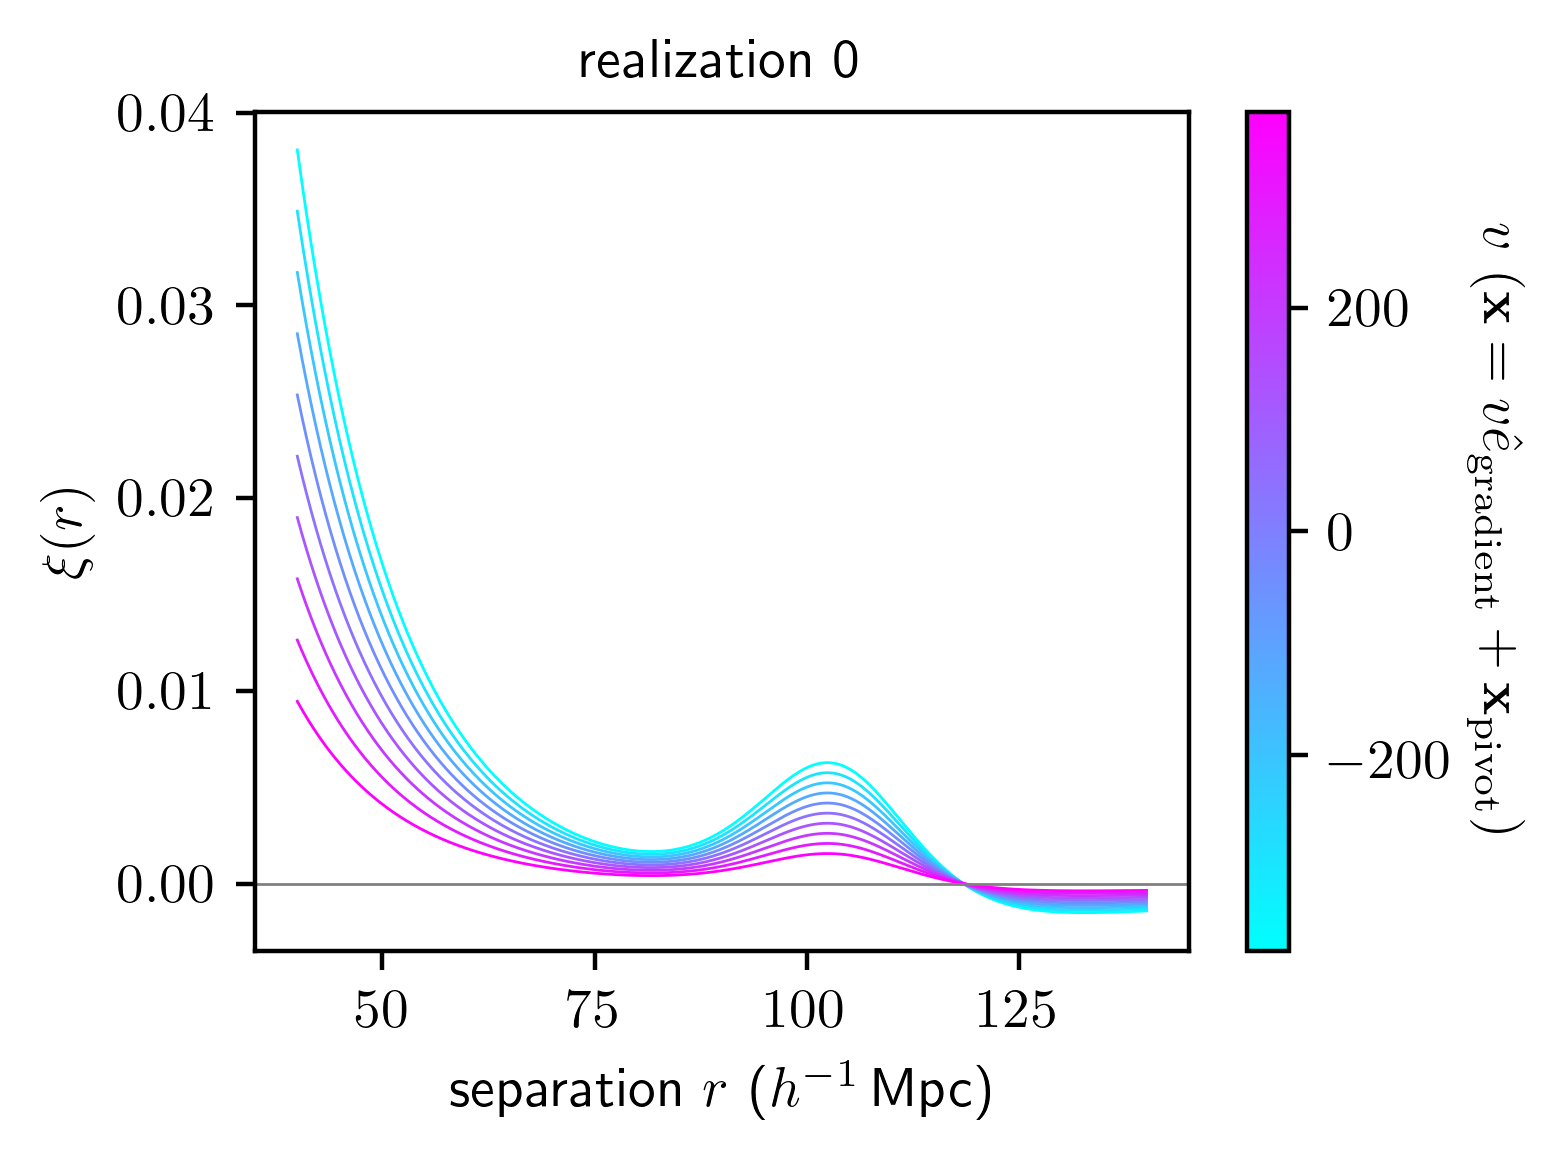

In [18]:
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 10
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    loc = loc_pivot + v*w_cont_hat
    if i==len(vs)-1:
        print(loc)
    weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
    weights2 = weights1 #because we just take the average of these and want to get this back
    
    xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    
    
    p = plt.plot(r_fine, xi_loc, color=cmap(vs_norm(v)), lw=0.5)
    
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{gradient} + \mathbf{x}_\mathrm{pivot})$', rotation=270, labelpad=12)
ax.axhline(0, color='grey', lw=0.5)
plt.title(f"realization {realization}")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Let's see if the recovered gradient makes sense!

In [28]:
print("amps = ", amps)
w_cont = amps[1:]/amps[0]
print("w_cont = ", w_cont)
print(f"||w_cont|| = {np.linalg.norm(w_cont):.6f}")
print(f"If we assume an initial b=0.5, this gives m = {np.linalg.norm(w_cont)*0.5*boxsize:.4f}/L")

amps =  [ 7.31328274e-01  3.23345937e-04 -1.37056719e-04 -1.30004132e-03]
w_cont =  [ 0.00044214 -0.00018741 -0.00177764]
||w_cont|| = 0.001841
If we assume an initial b=0.5, this gives m = 0.6905/L


## Now let's check out 100 realizations!

[375. 375. 375.]


Text(0, 0.5, '$\\xi(r)$')

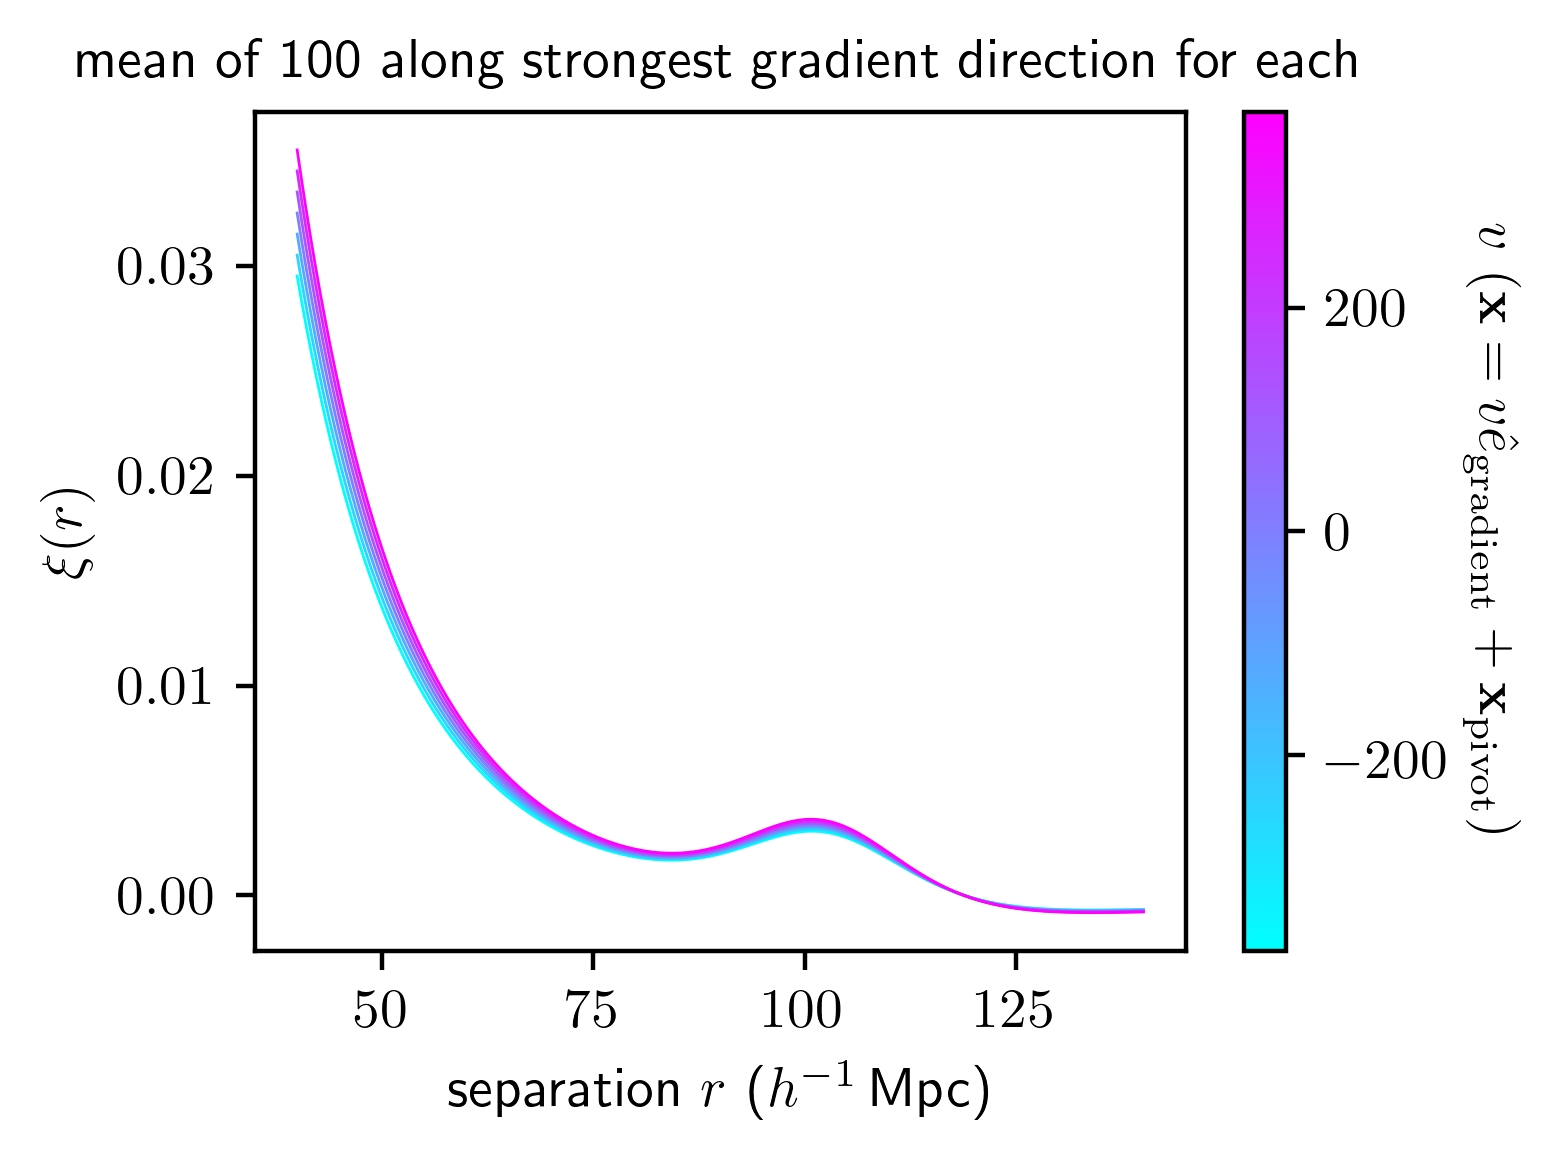

In [31]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 7
vs = np.linspace(v_min, v_max, nvs)

w_conts = np.empty((len(realizations), 3))

for i, v in enumerate(vs):
    
    xis = []
    for n, Nr in enumerate(realizations):
        
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        w_cont = amps[1:]/amps[0]
        w_conts[n] = w_cont
        w_cont_hat = v_grad/np.linalg.norm(w_cont)
        
        proj_type, projfn, weight_type, loc_pivot = \
                   extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
        loc_pivot = np.array(loc_pivot)

        loc = loc_pivot + v*w_cont_hat
        weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
        weights2 = weights1 #because we just take the average of these and want to get this back
        xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    

        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(vs_norm(v)), alpha=1, lw=0.5)   

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{gradient} + \mathbf{x}_\mathrm{pivot})$', 
               rotation=270, labelpad=12)

plt.title(f"mean of {len(realizations)} along strongest gradient direction for each")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Text(0, 0.5, 'count')

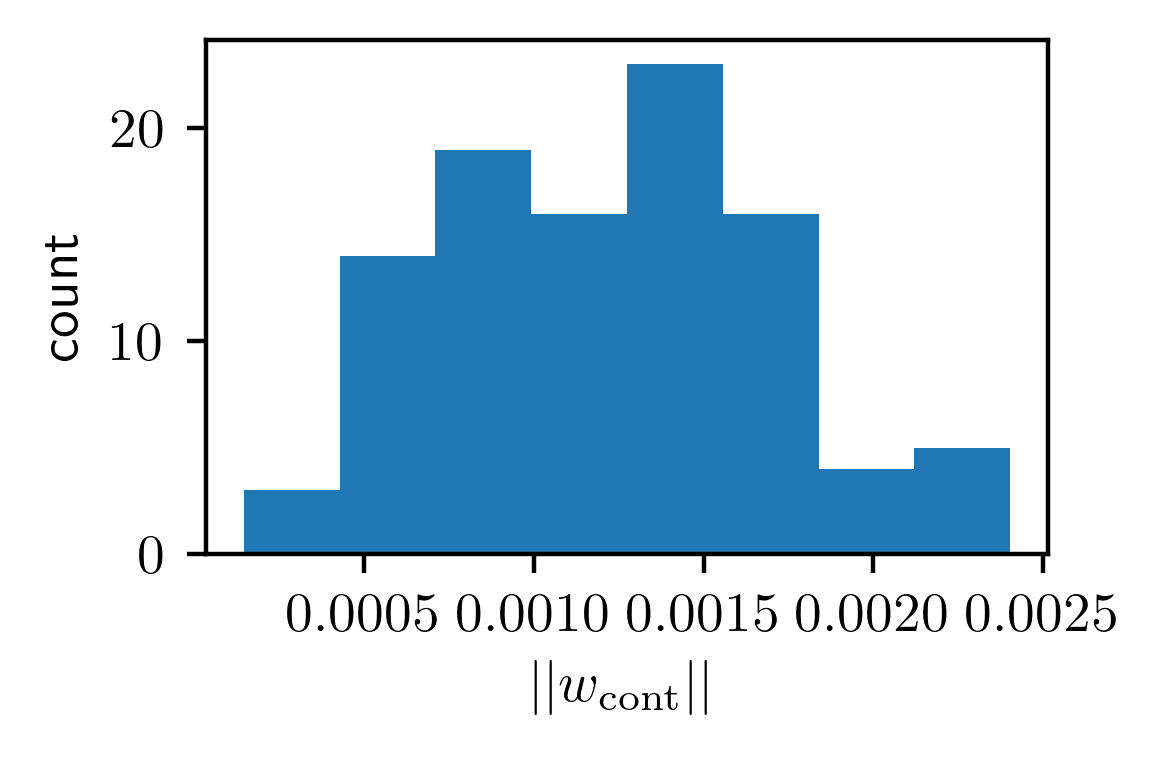

In [39]:
w_conts_norm = np.linalg.norm(w_conts, axis=1)
plt.figure(figsize=(3,2))
plt.hist(w_conts_norm, bins=8)
plt.xlabel('$||w_\mathrm{cont}||$')
plt.ylabel('count')

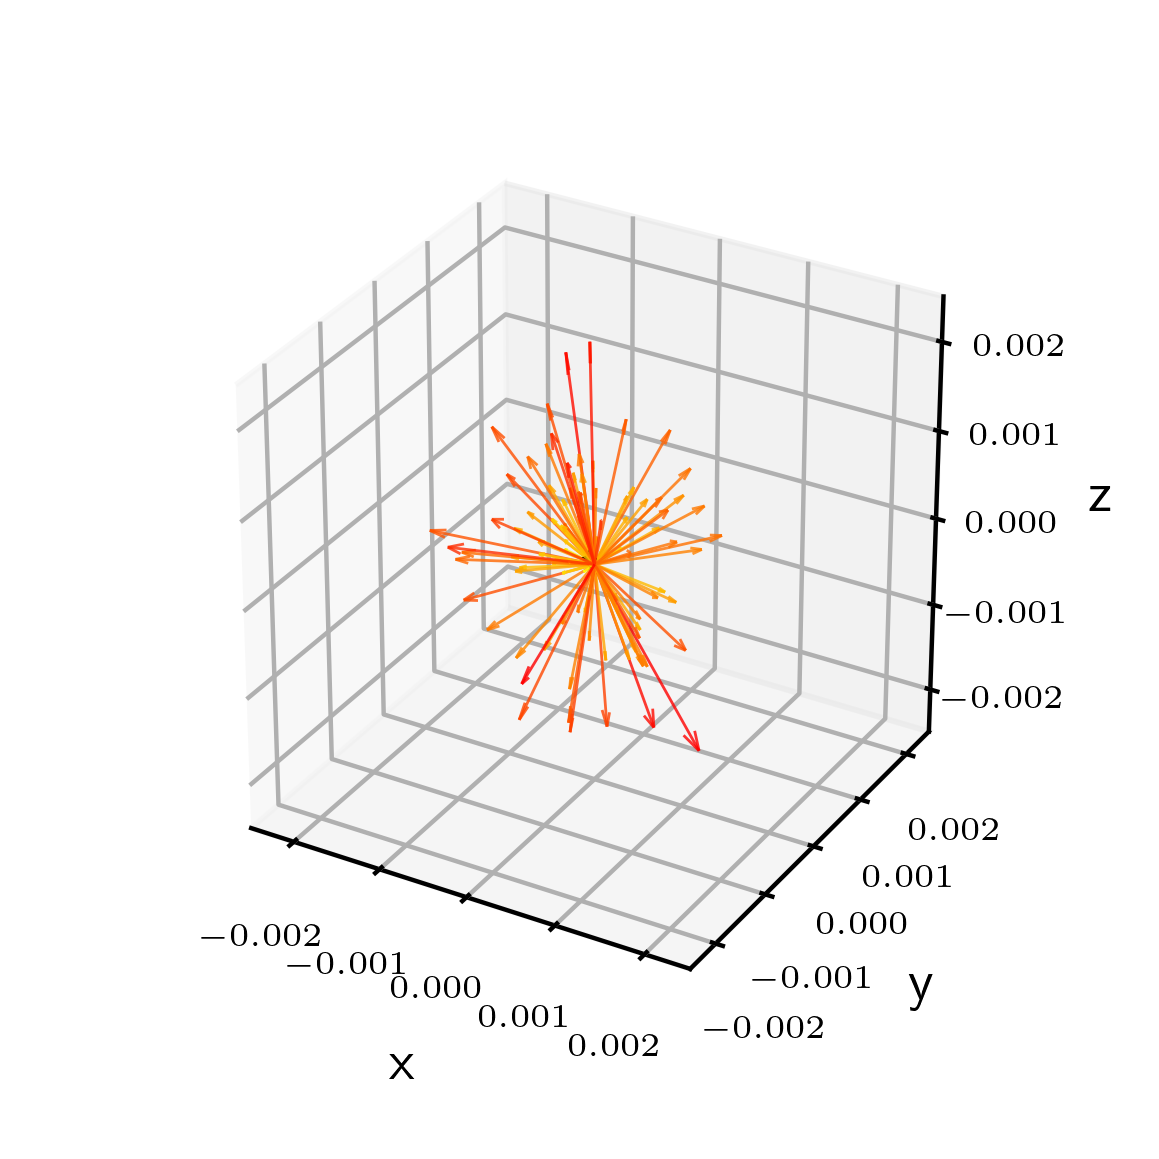

In [59]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(3,3))
ax = fig.gca(projection='3d')

mag_min = min(w_conts_norm)
mag_max = max(w_conts_norm)
mag_norm = matplotlib.colors.Normalize(vmin=mag_min, vmax=mag_max)
cmap = matplotlib.cm.get_cmap('autumn_r')

for i in range(w_conts.shape[0]):
    w_zero = np.zeros(3)
    w_cont = w_conts[i]
    w_cont_norm = np.linalg.norm(w_cont)
    plt.quiver(w_zero[0], w_zero[1], w_zero[2], w_cont[0], w_cont[1], w_cont[2], 
              color=cmap(v_norm(w_cont_norm)), arrow_length_ratio=0.1, lw=0.5, alpha=0.8)
    
w_mean = np.mean(w_conts, axis=0)    
plt.quiver(w_zero[0], w_zero[1], w_zero[2], w_mean[0], w_mean[1], w_mean[2], 
              color='k', arrow_length_ratio=0.1, lw=2, zorder=10000)

ax.set_xlim(-mag_max, mag_max)
ax.set_ylim(-mag_max, mag_max)
ax.set_zlim(-mag_max, mag_max)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.dist = 12
ax.tick_params(labelsize=6)

In [60]:
print("w_mean = ", w_mean)

w_mean =  [-2.26891701e-05 -1.20927045e-04  1.55646663e-04]
